In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import helper


In [2]:
results = pkl.load(open("modeling_results_all.pkl","rb"))
#print(results)
results = results[results["Score"] < results["Training Score"]]
#results = results[results["Score"] > results["Training Score"] * 2/3]
bestParams = results[results["Score"] == results["Score"].max()]
ind = bestParams.index.values[0]
print(bestParams)
print(bestParams.at[ind,"Params"])
baseline = bestParams.at[ind,"Baseline"]
params = bestParams.at[ind,"Params"]
model = bestParams.at[ind,"Model"]
model_names = ["Logistic Regression","ElasticNet","PLSDA","SVM","Random Forest"]
model_train_funcs = [helper.trainLogisticRegression,helper.trainElasticNet,helper.trainPLSDA,helper.trainSVM,helper.trainRF]
model_predict_funcs = [helper.predictLogisticRegression,helper.predictElasticNet,helper.predictPLSDA,helper.predictSVM,helper.predictRF]
train_mapping = {name:func for name,func in zip(model_names,model_train_funcs)}
predict_mapping = {name:func for name,func in zip(model_names,model_predict_funcs)}

trainFunc,predictFunc = train_mapping[model],predict_mapping[model]


   Model                                             Params Baseline  \
2  PLSDA  {'feat_selection': ('corr', 0.2222222222222222...     none   
7  PLSDA  {'feat_selection': ('corr', 0.2222222222222222...      all   

      Score  Training Score  
2  0.563437             1.0  
7  0.563437             1.0  
{'feat_selection': ('corr', 0.2222222222222222), 'n_components': 5}


In [3]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/08_10_2020_batch_1_6_polar_non_polar_id_unk_peak_areas.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[5:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/07_30_2020_batch_1_6_qTOF_polar_non_polar_experiment_parameters.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

metadata_val = metadata[metadata["day-COVID"] == "d0_No"]
print(len(metadata_val), "d0 Covid- Samples")

val_samples = []
for index,row in metadata_val.iterrows():
    val_samples.append(row["Sample General Name"])
    
val_cols = []
for val_s in val_samples:
    for col in range(len(areaCols)):
        if areaCols[col] == val_s:
            val_cols.append(col)
            break

            
#create sample name, ventilator status linkage
vent_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 1
    vent_dict[sampName] = val

print(np.sum(list(vent_dict.values()))," vent+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values()))," vent- samples")

#link vent status to sample in peak data
vent_status = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
    else:
        vent_status.append(-1)

print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

val_int = areaData[val_cols]
val_batch = np.array(batchInfo)[val_cols]
val_vent = np.array([0 for _ in val_batch])

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = areaData[samp][samplesOfInterest]
samp_vent = np.array(vent_status)[samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

0  blanks
0  qc samples
530 research samples
168  d0 Covid+ Samples
35 d0 Covid- Samples
168  vent+ samples
0  vent- samples
found vent info for 168 covid_ d0 samples


474411


No handles with labels found to put in legend.


108766


Text(0, 0.5, 'PC2')

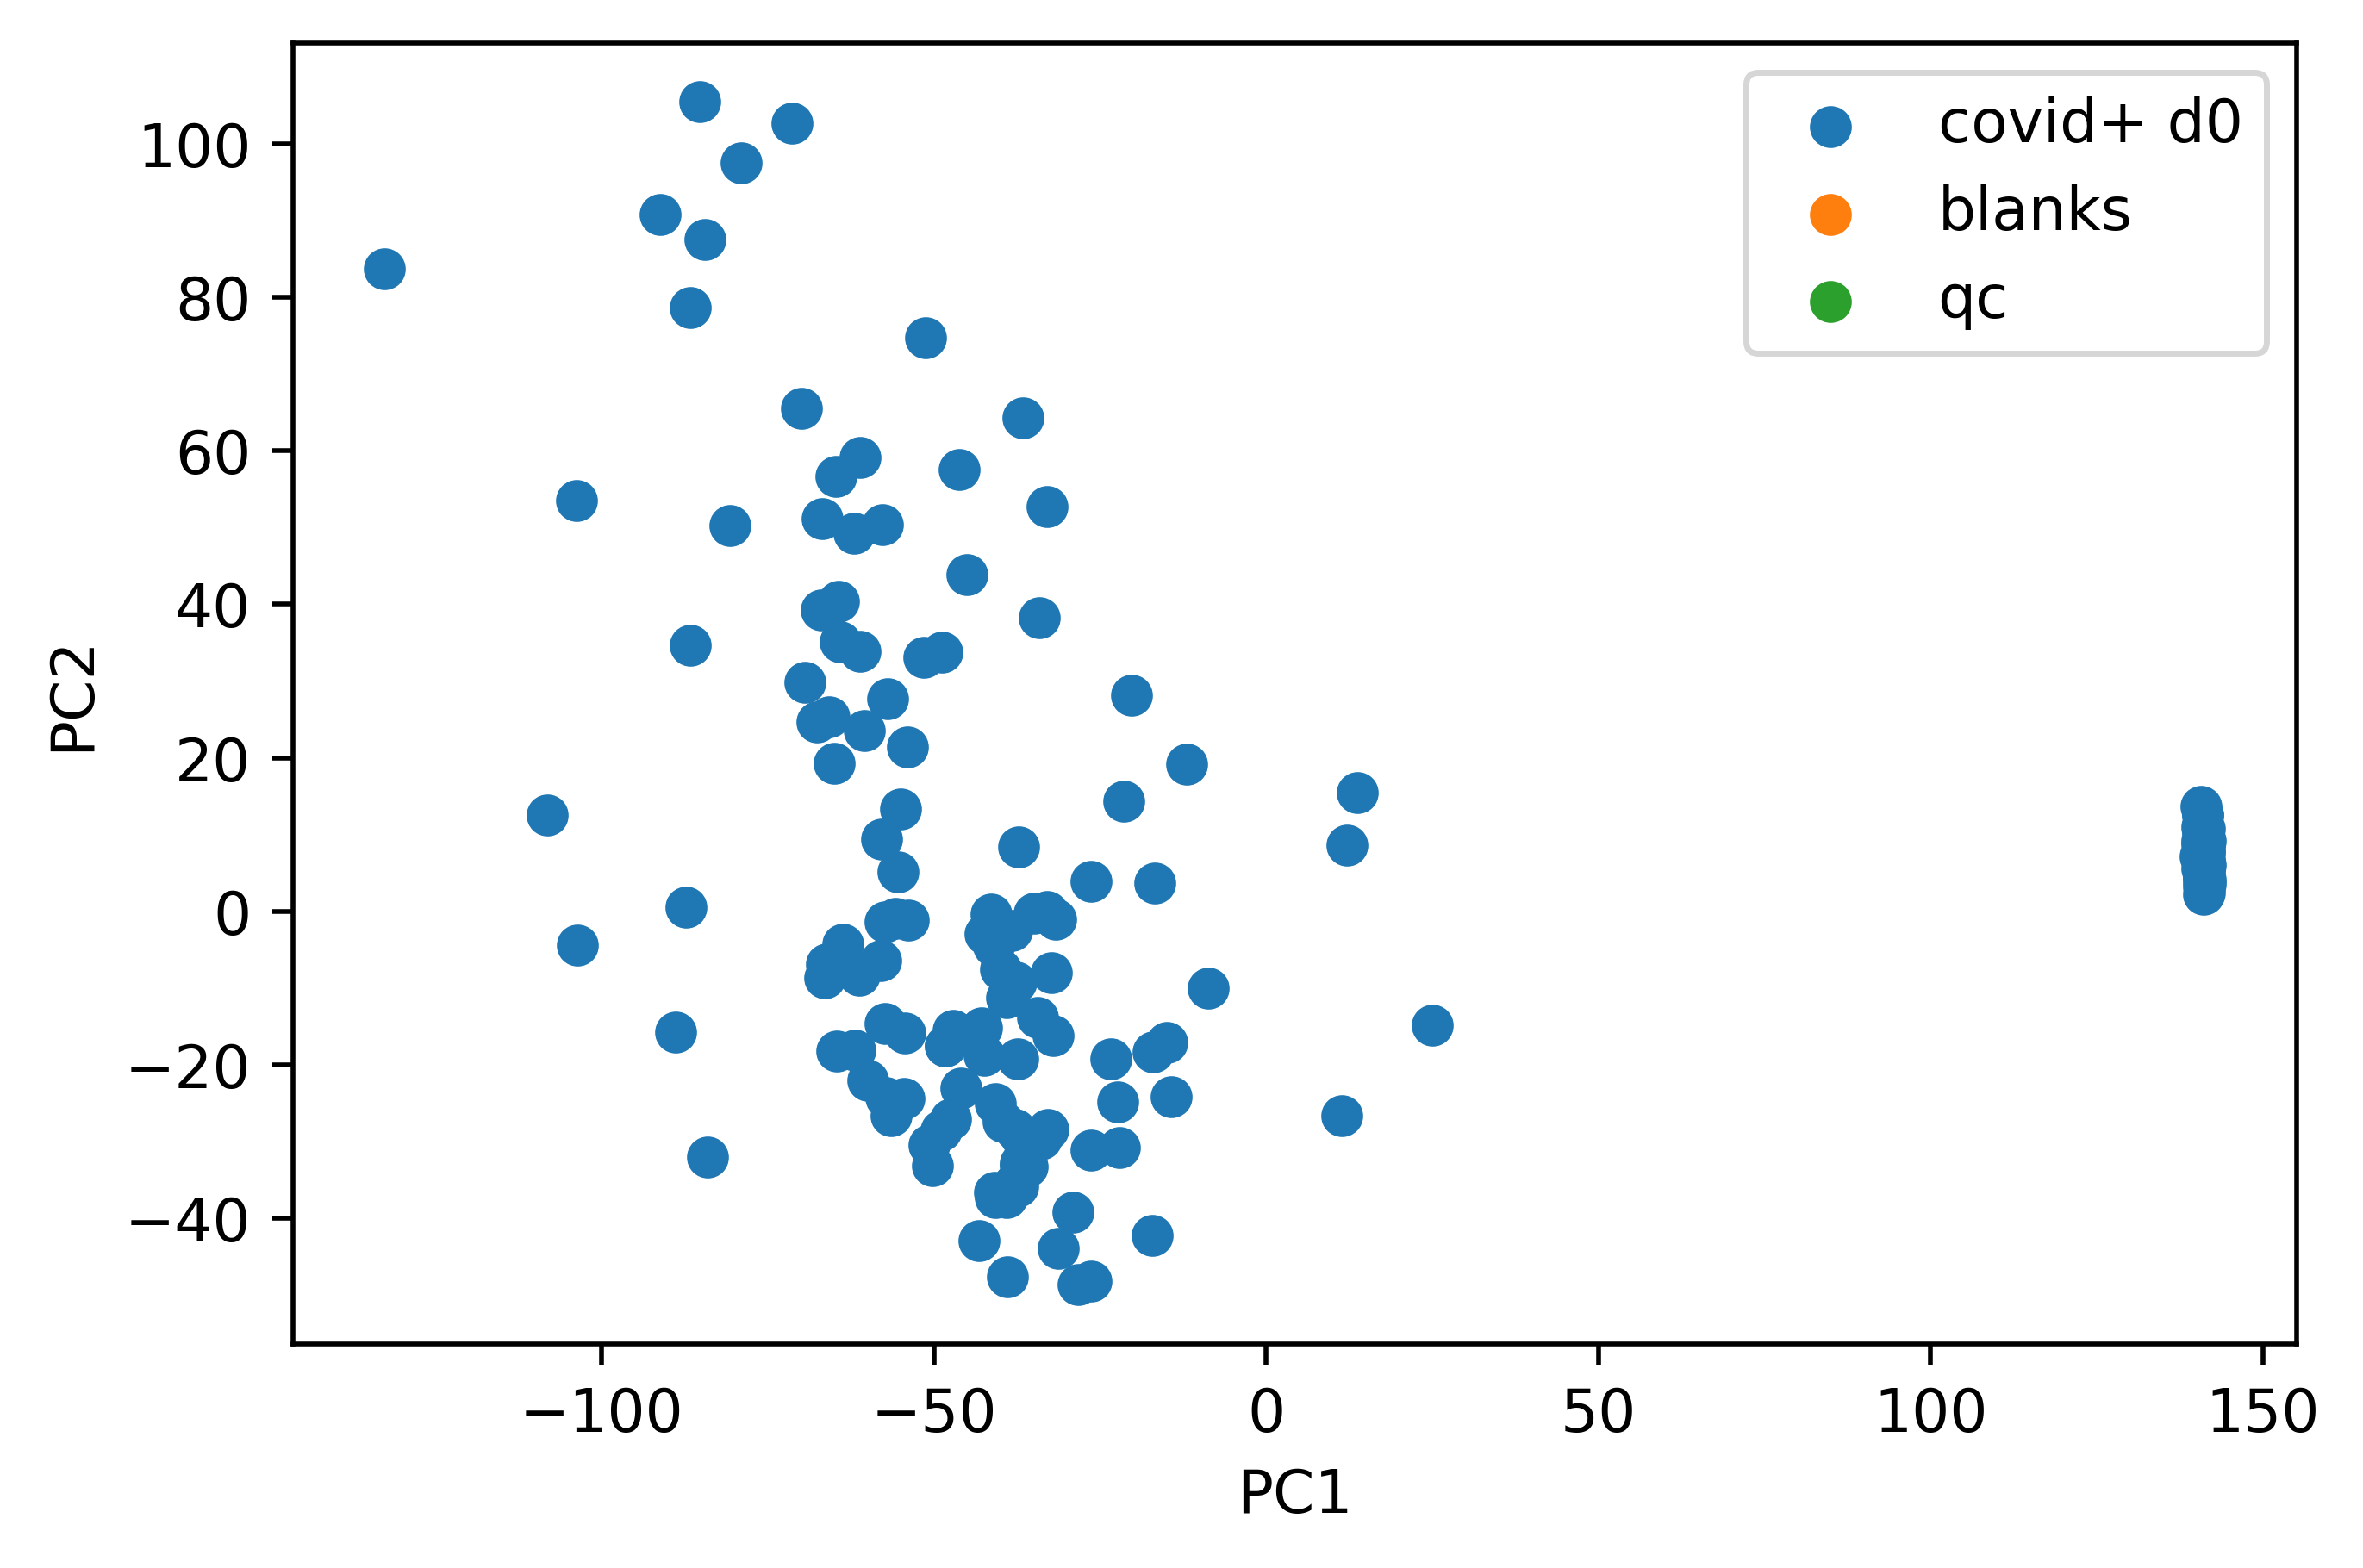

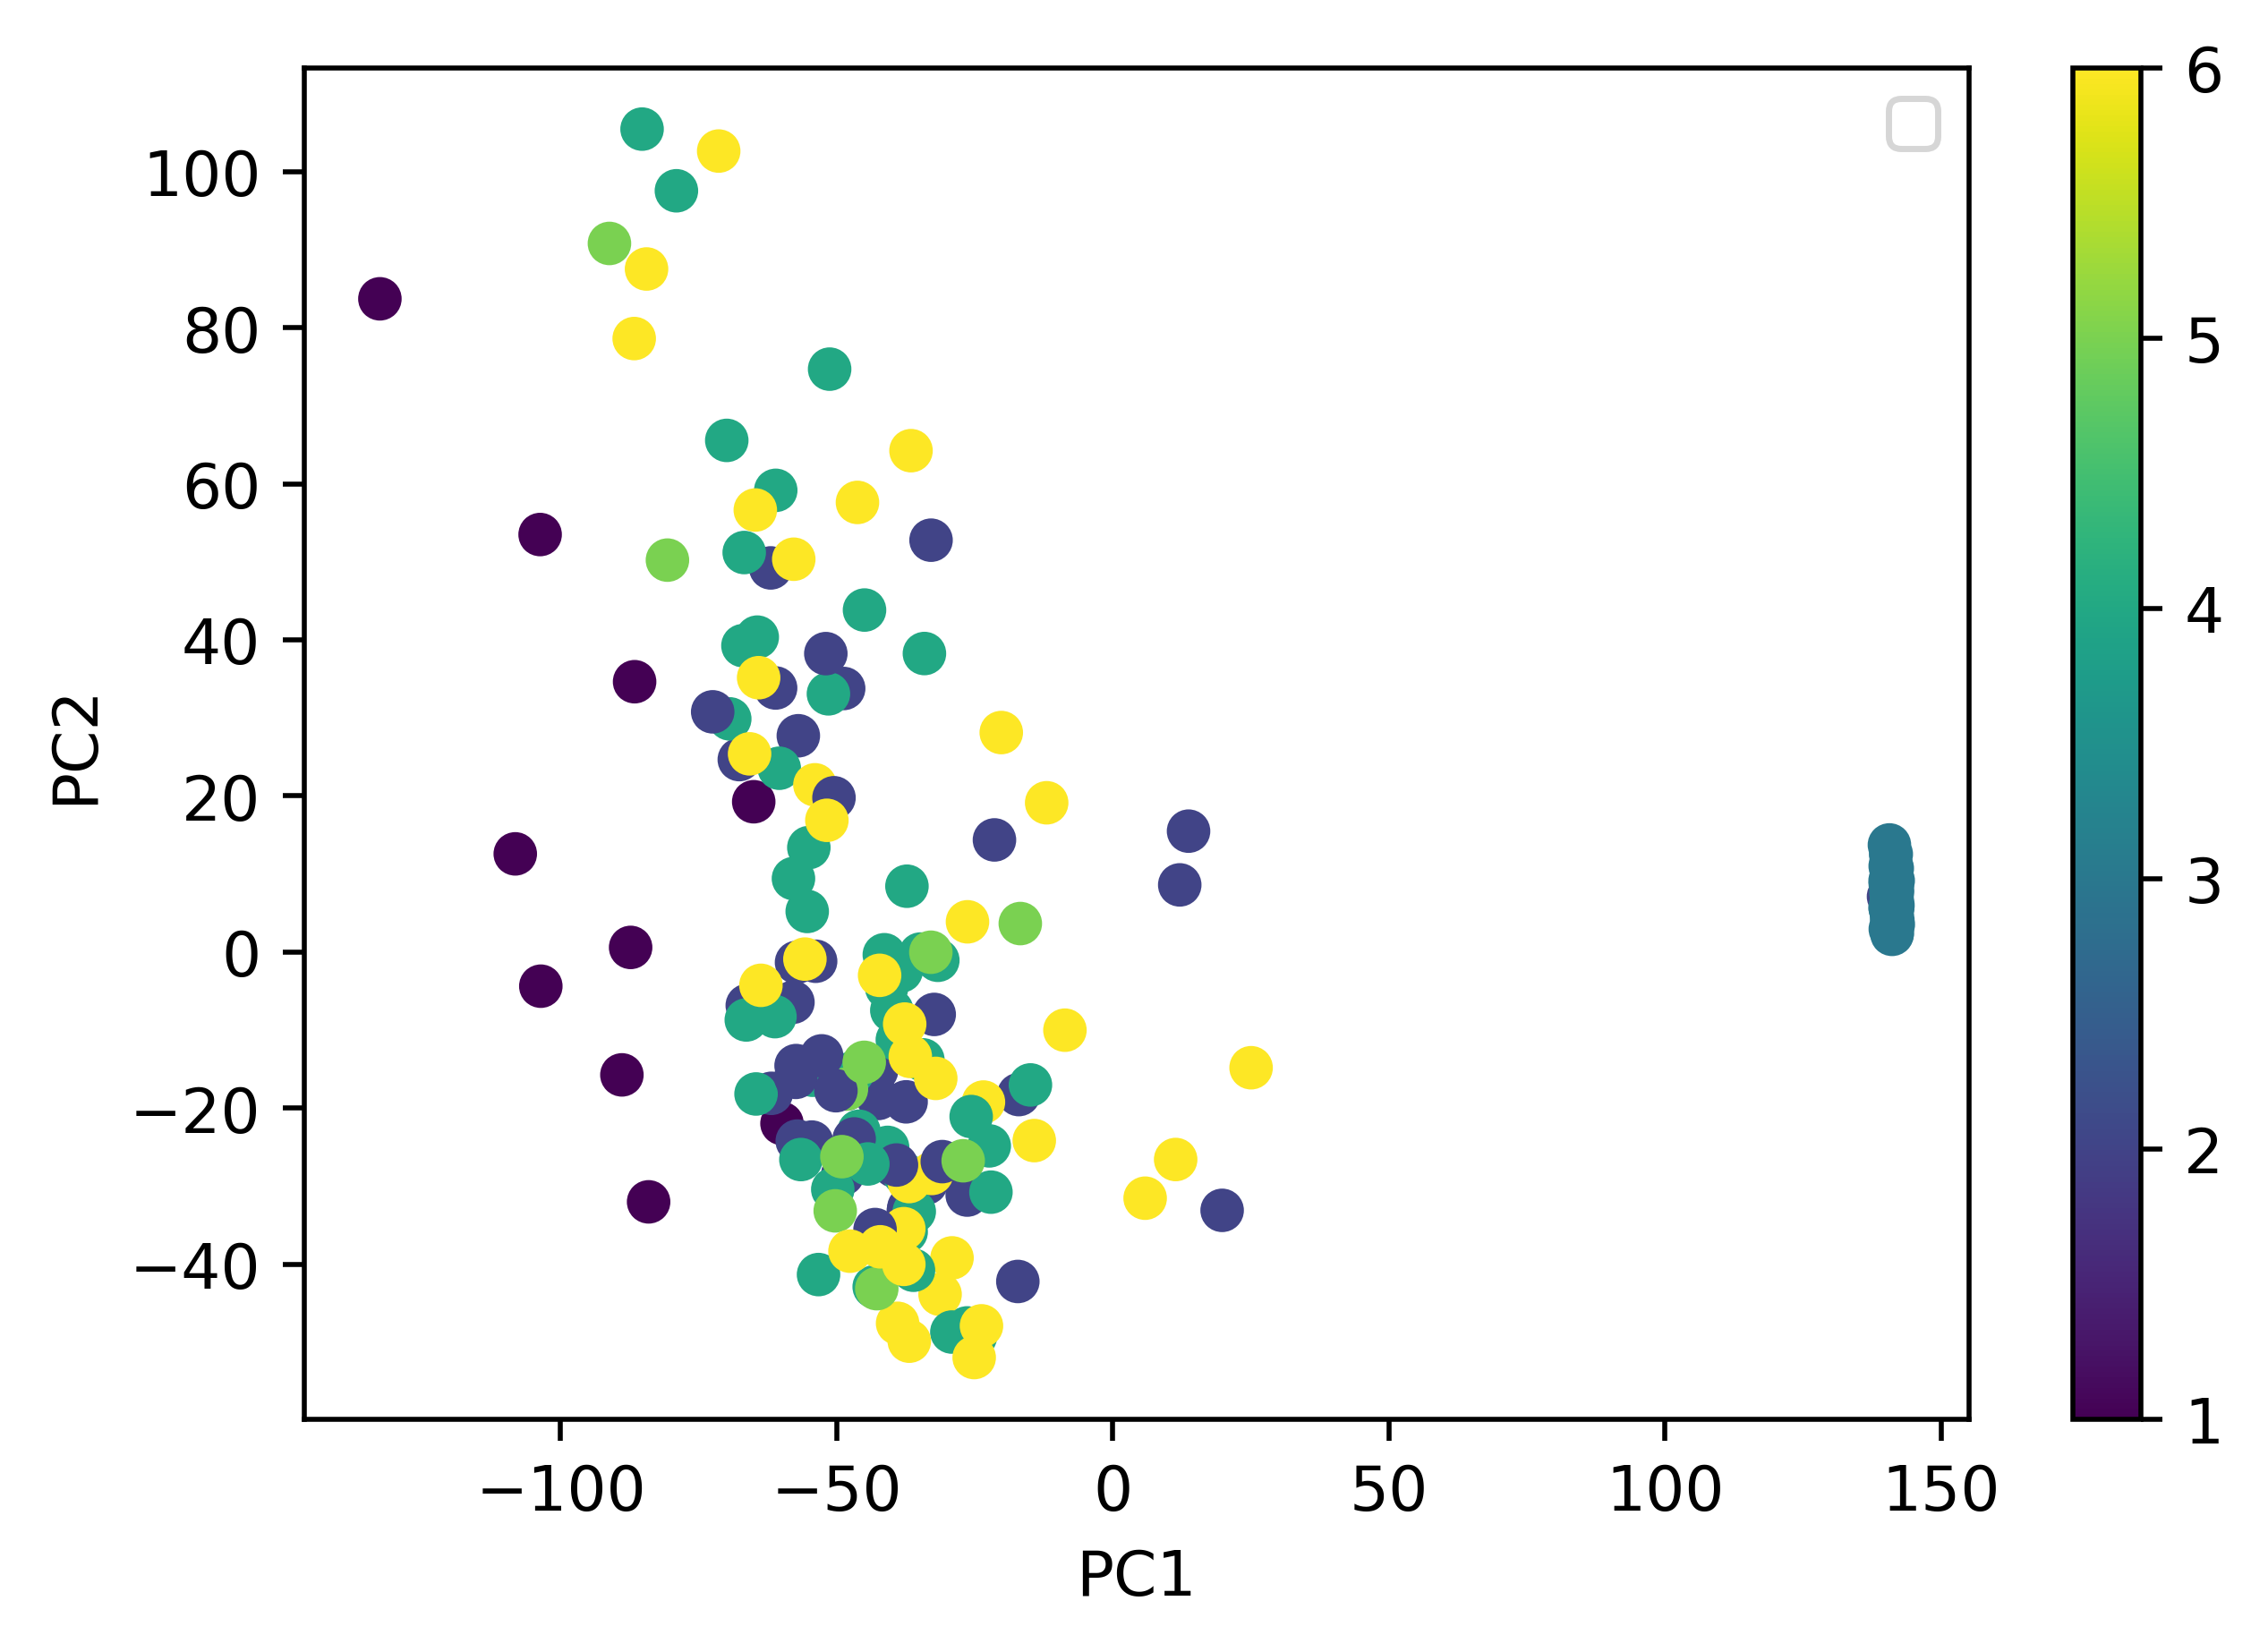

In [4]:
#visualize complete dataset

#first impute dataset
d_whole = np.concatenate((samp_int,blank_int,qc_int,val_int))
d_whole_imput = helper.imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
No handles with labels found to put in legend.


Adjusting data


Text(0, 0.5, 'PC2')

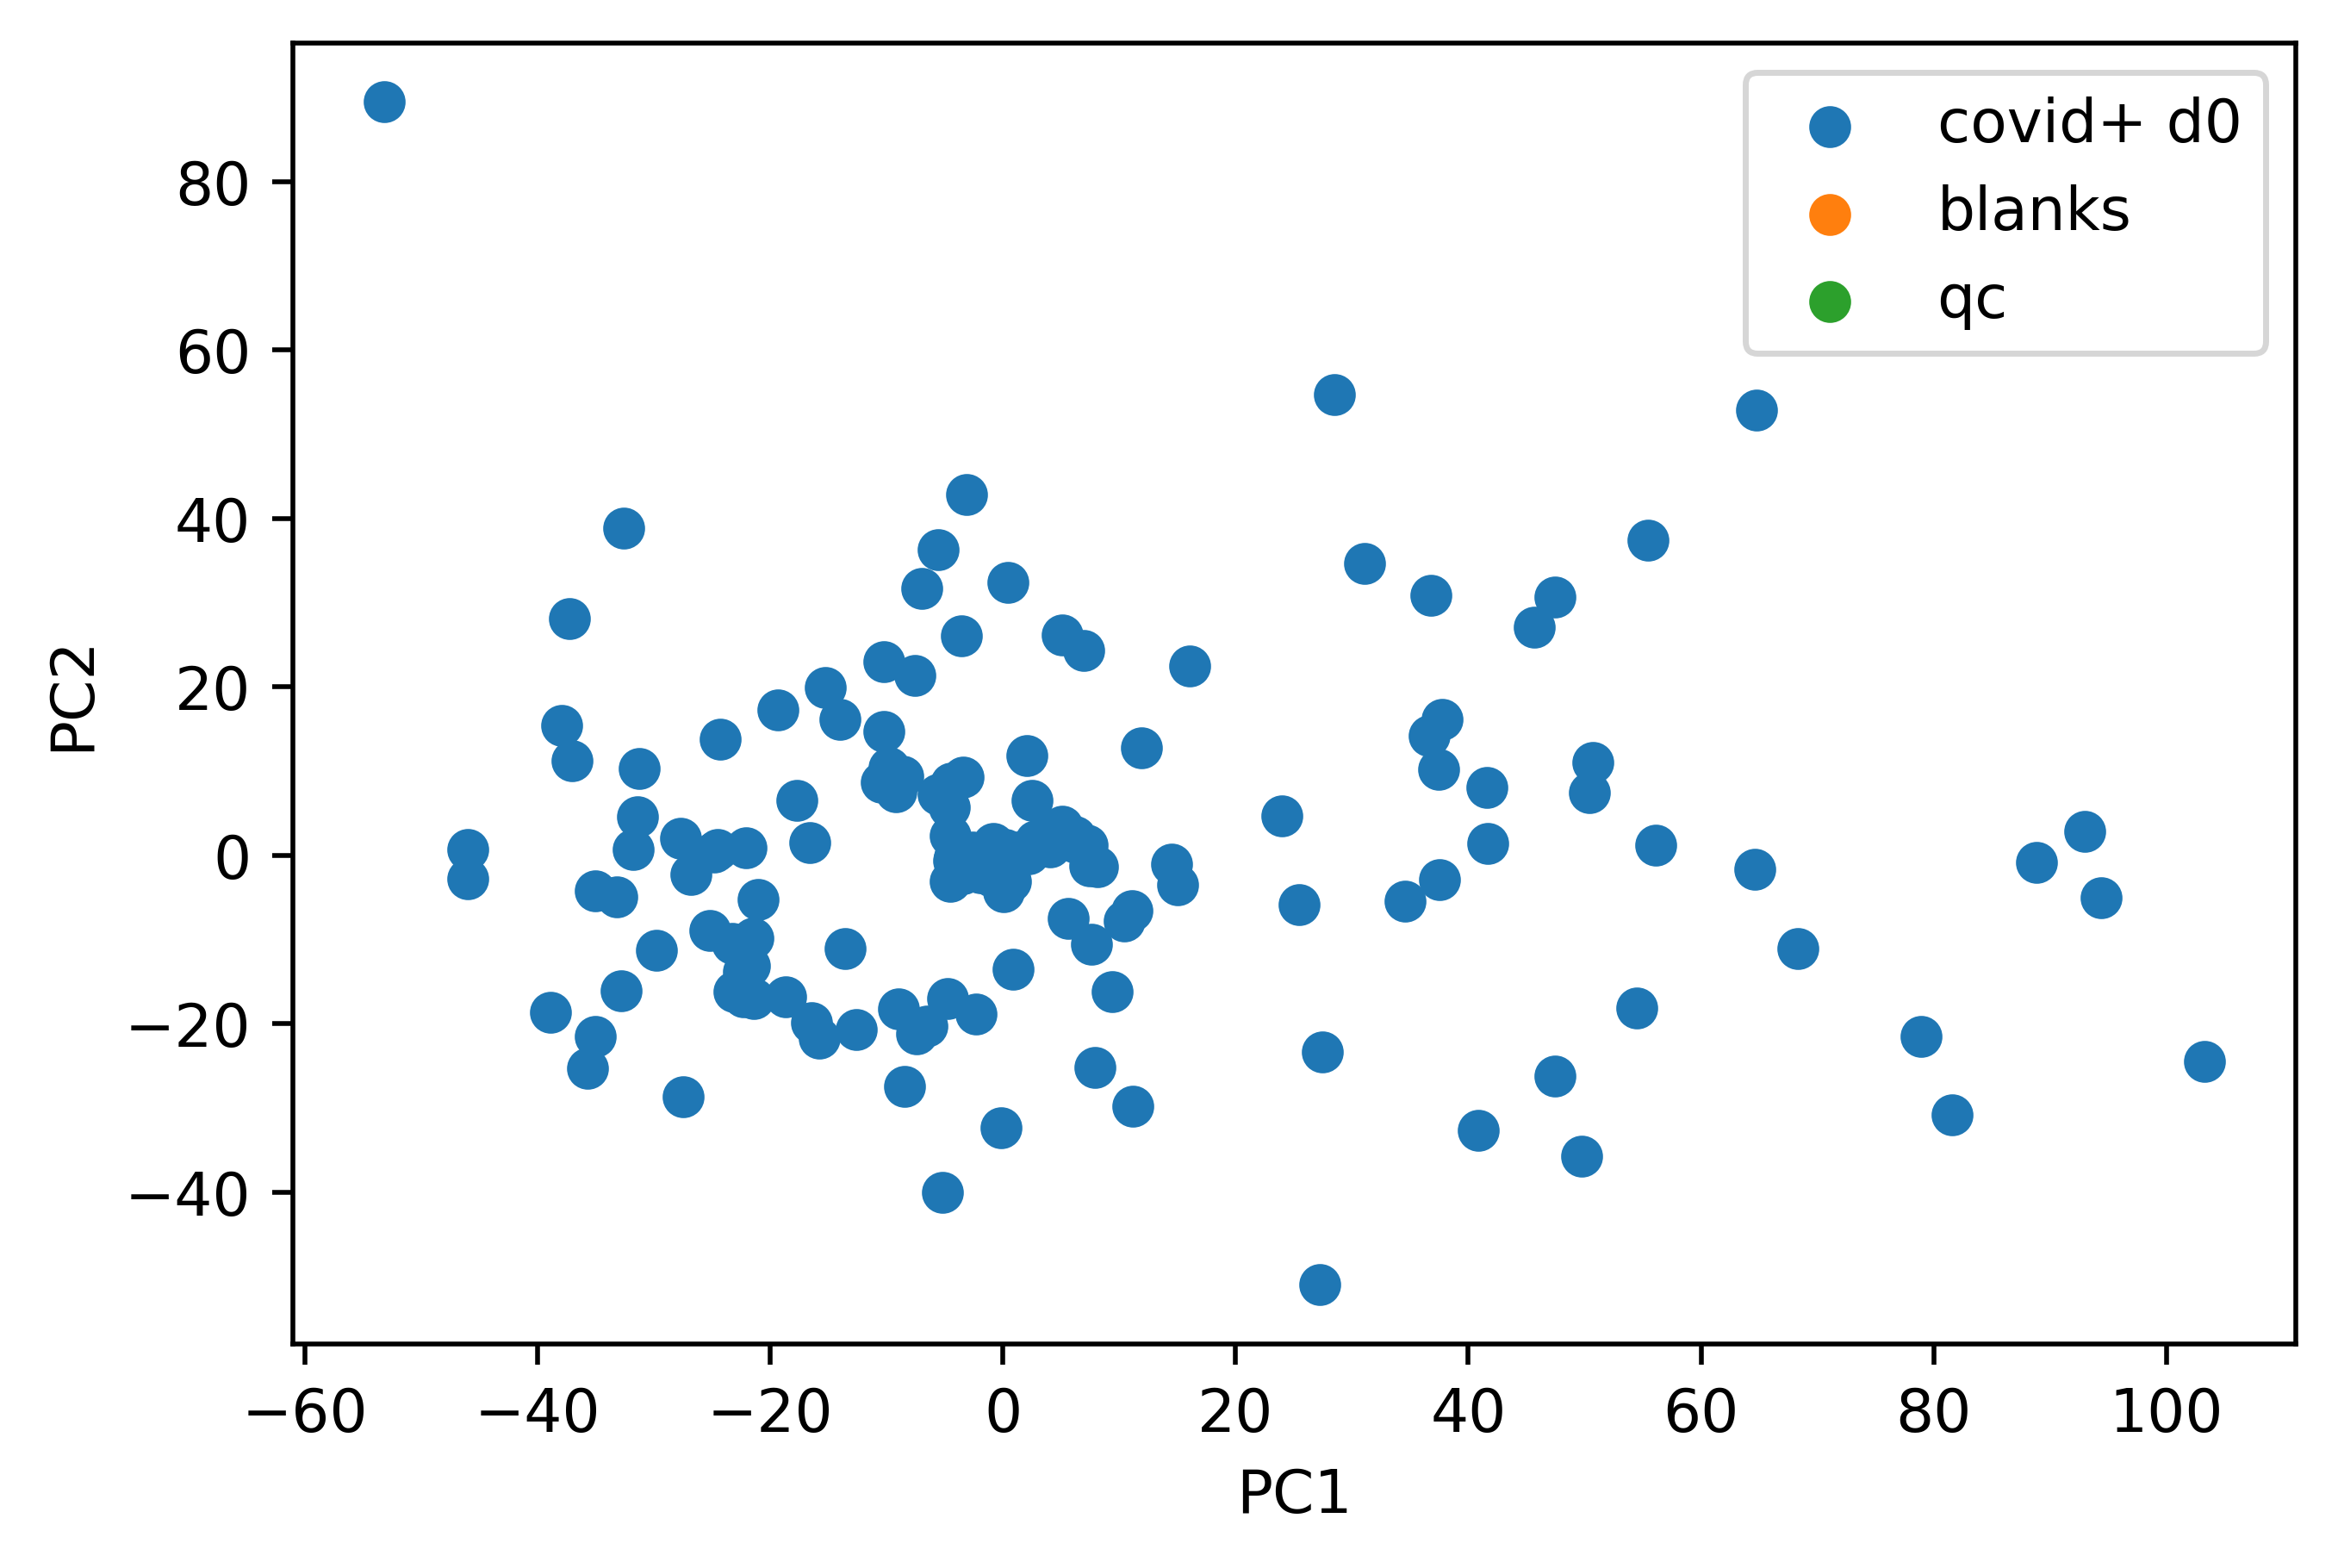

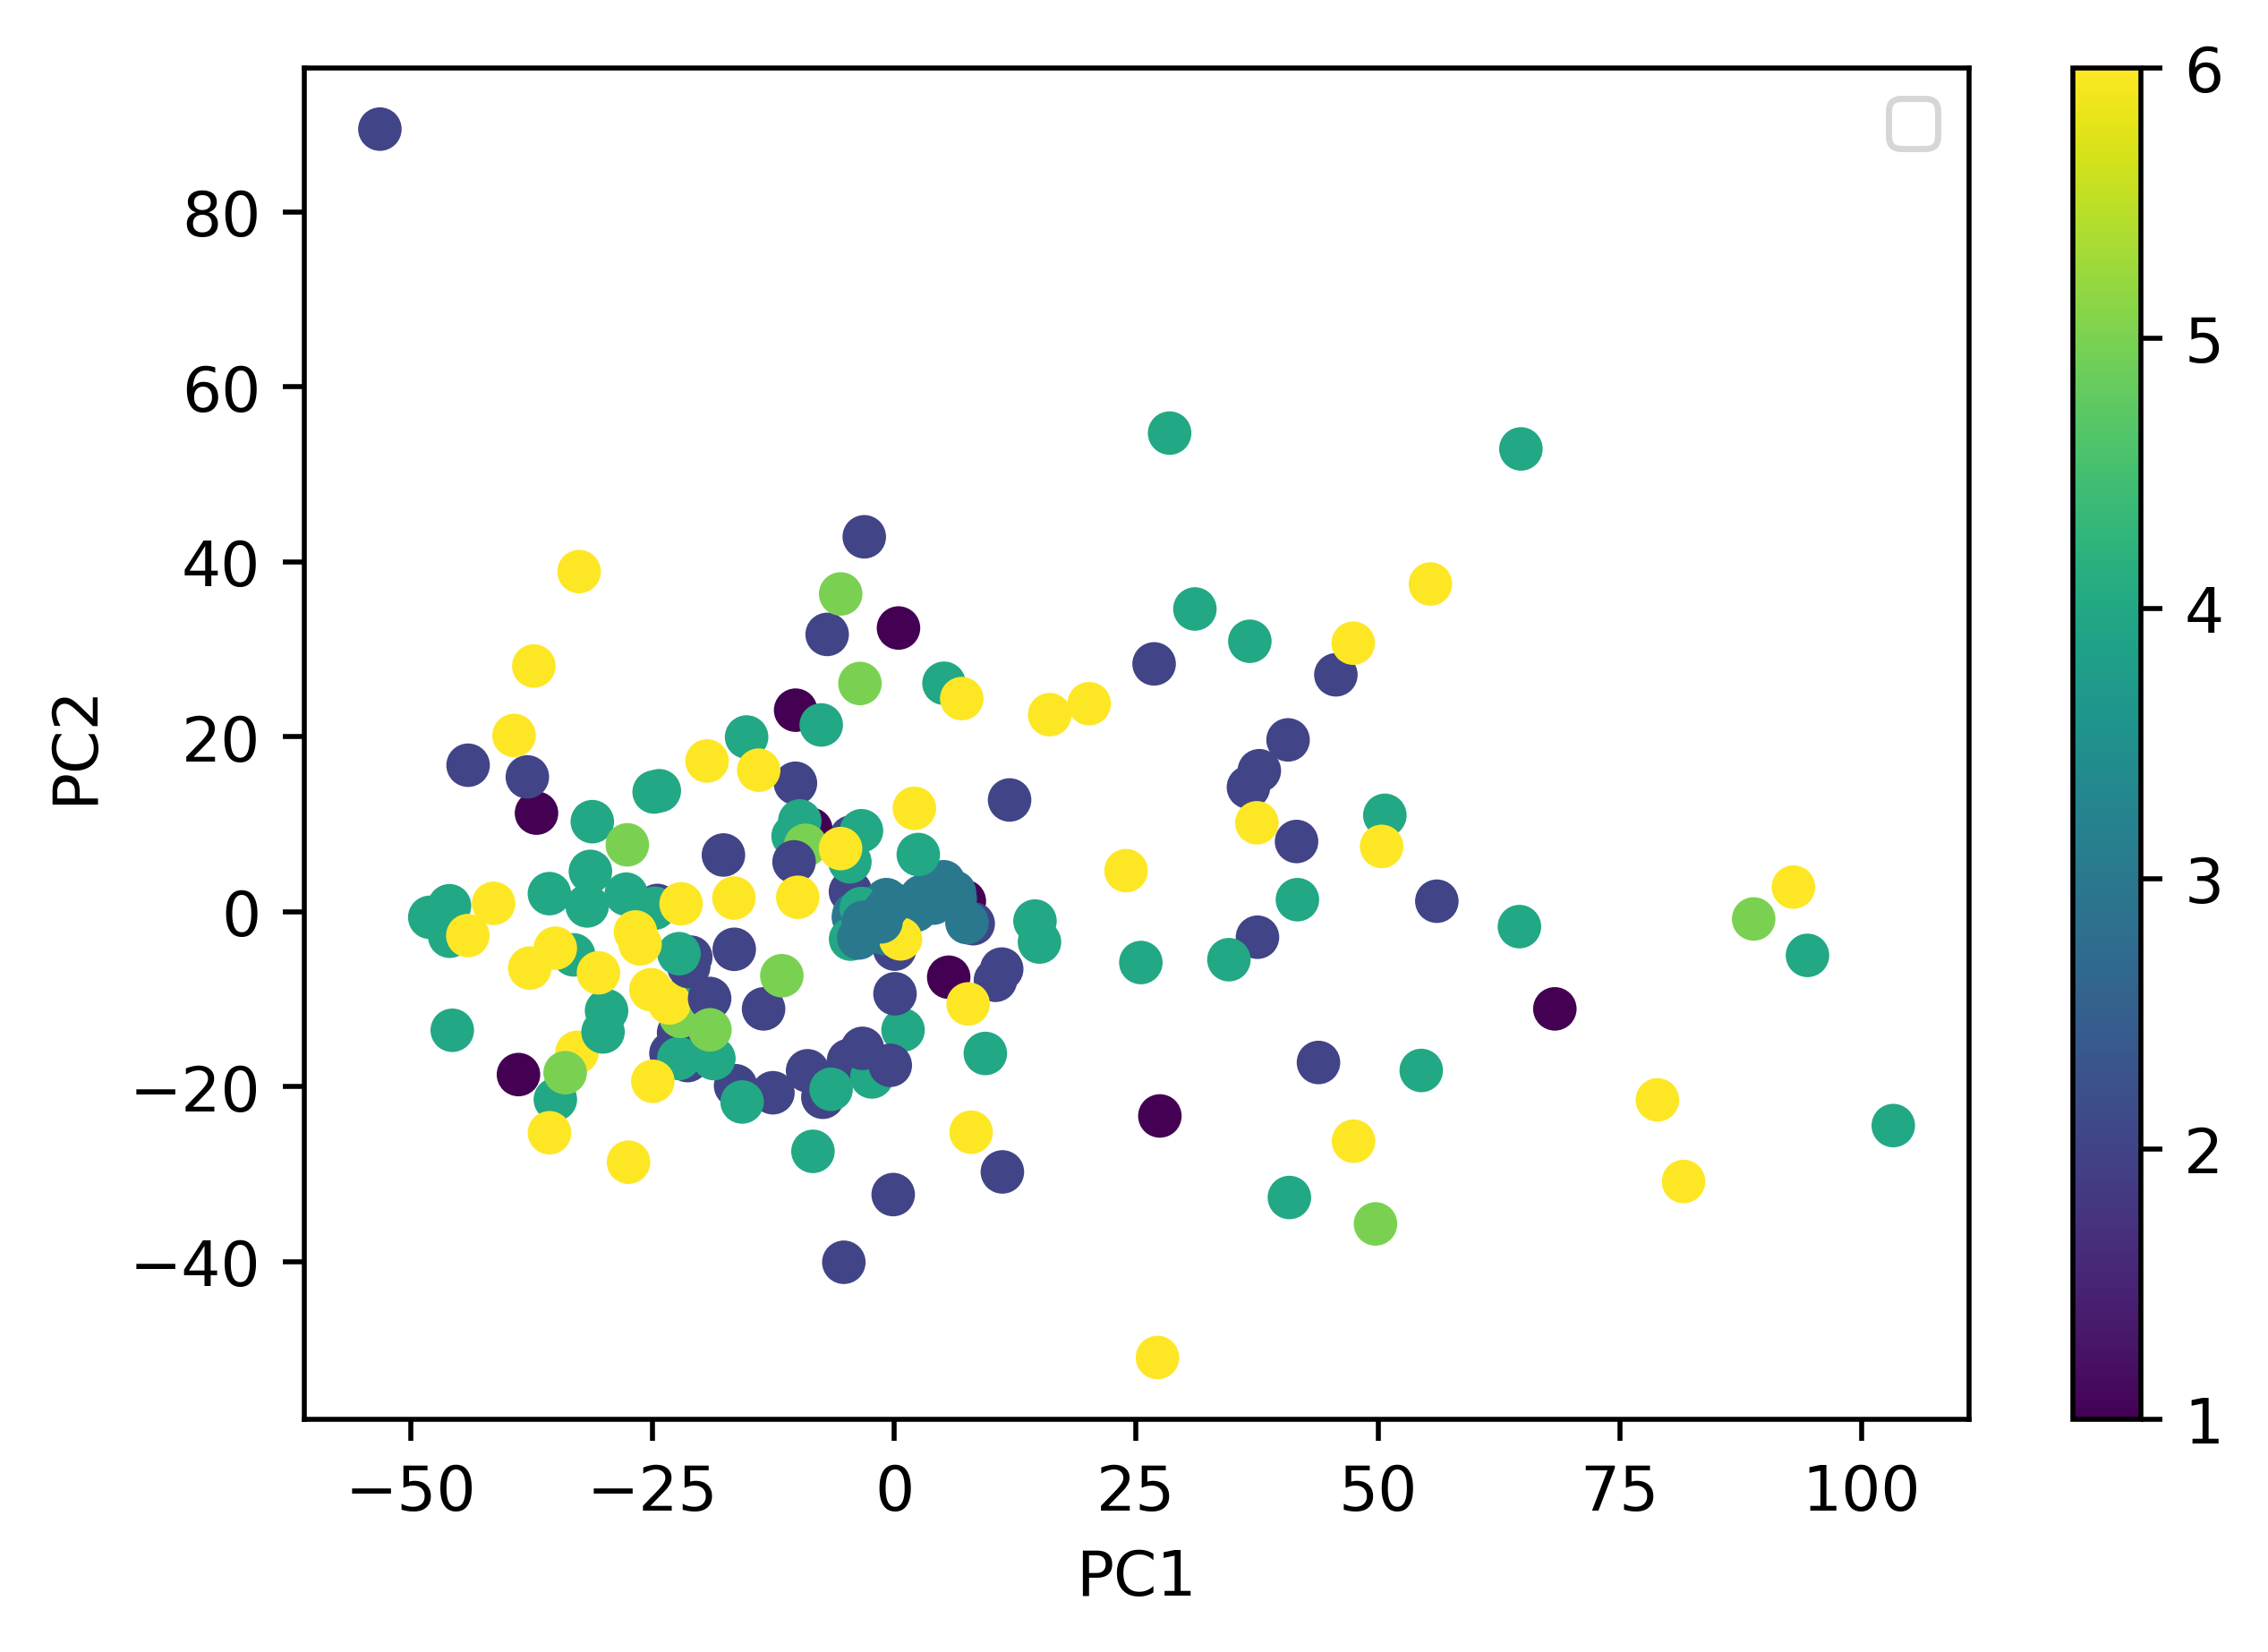

In [5]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))).transpose().to_numpy()


#baseline

if baseline == "qc":
    # #baseline to qcSamps
    baseInt = [np.median(x) for x in d_whole_norm[len(samp_int) + len(blank_int):].transpose()]
    d_whole_norm = np.array([[v - med for v, med in zip(row, baseInt)] for row in d_whole_norm])

if baseline == "all":
    baseInt = [np.median(x) for x in d_whole_norm.transpose()]
    d_whole_norm = np.array([[v - med for v, med in zip(row, baseInt)] for row in d_whole_norm])




#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



Text(0, 0.5, 'PC2')

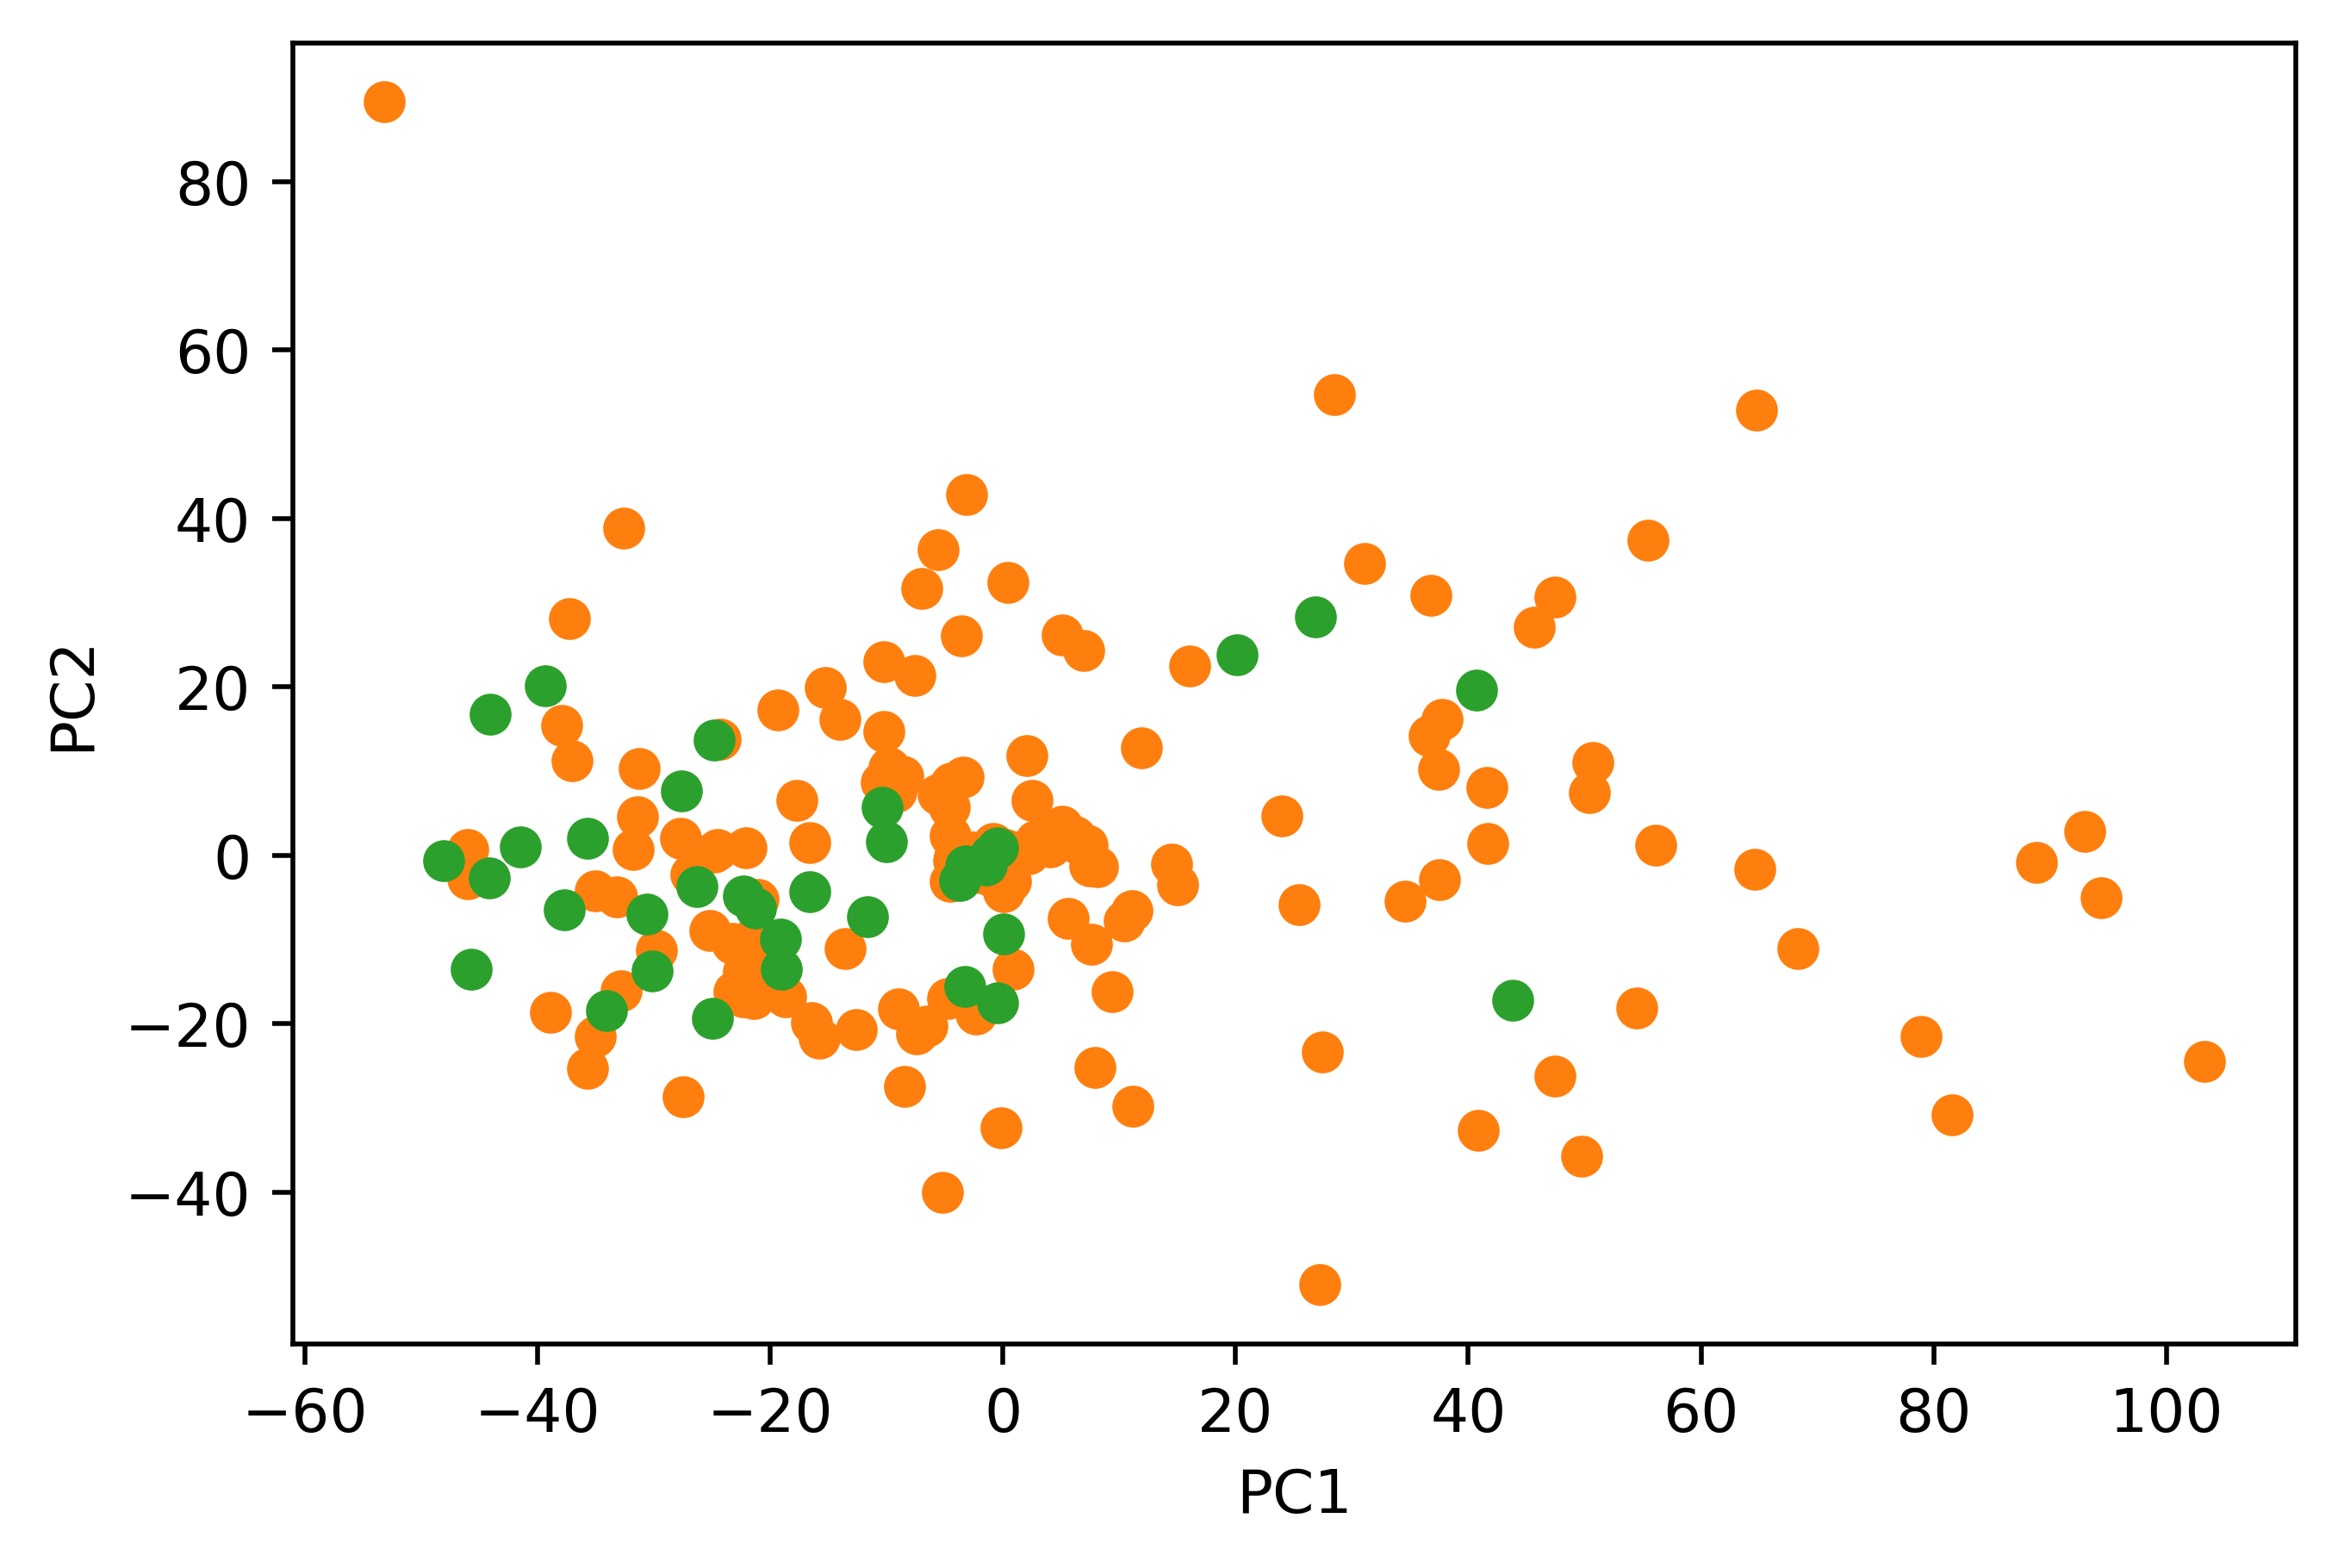

In [6]:
#now plot research samples by vent status
#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 0]
posSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]
val_load = loads[len(samp_int)+len(blank_int)+len(qc_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="vent- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="vent+ covid+ d0")
#plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
#plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.scatter(val_load[:,0],val_load[:,1],label="covid-")
#plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



In [7]:
#create train and test sets for prediction model

#train batches on 1-4
#test on 5-6

trainBatches = [1,2,3,4]
testBatches = [5,6]


#get blanks for train/test
blank_train_index = [x for x in range(len(blank_batch)) if blank_batch[x] in trainBatches]
blank_test_index = [x for x in range(len(blank_batch)) if blank_batch[x] in testBatches]

blank_train_int = blank_int[blank_train_index]
blank_test_int = blank_int[blank_test_index]

blank_train_batch = blank_batch[blank_train_index]
blank_test_batch = blank_batch[blank_test_index]

#get samples for train/test
samp_train_index = [x for x in range(len(samp_batch)) if samp_batch[x] in trainBatches]
samp_test_index = [x for x in range(len(samp_batch)) if samp_batch[x] in testBatches]

samp_train_int = samp_int[samp_train_index]
samp_test_int = samp_int[samp_test_index]

samp_train_vent = samp_vent[samp_train_index]
samp_test_vent = samp_vent[samp_test_index]

samp_train_batch = samp_batch[samp_train_index]
samp_test_batch = samp_batch[samp_test_index]

#get qc for train/test

qc_train_index = [x for x in range(len(qc_batch)) if qc_batch[x] in trainBatches]
qc_test_index = [x for x in range(len(qc_batch)) if qc_batch[x] in testBatches]

qc_train_int = qc_int[qc_train_index]
qc_test_int = qc_int[qc_test_index] 

qc_train_batch = qc_batch[qc_train_index]
qc_test_batch = qc_batch[qc_test_index] 

#need to add vent and qcs

print("training examples: ",len(samp_train_int),"testing examples: ",len(samp_test_int))
print("training vent+ examples:, ",len([x for x in samp_train_vent if x == 1]),
      "training vent- examples:, ",len([x for x in samp_train_vent if x == 0]))
print("testing vent+ examples:, ",len([x for x in samp_test_vent if x == 1]),
      "testing vent- examples:, ",len([x for x in samp_test_vent if x == 0]))

training examples:  132 testing examples:  36
training vent+ examples:,  132 training vent- examples:,  0
testing vent+ examples:,  36 testing vent- examples:,  0


In [8]:
X_train,y_train,X_test,y_test,X_train_blank = helper.normalize_data(samp_train_int,blank_train_int,qc_train_int,np.concatenate((samp_test_int,val_int)), blank_test_int, qc_test_int,samp_train_batch,
                           blank_train_batch, qc_train_batch, np.concatenate((samp_test_batch,val_batch)), blank_test_batch, qc_test_batch,samp_train_vent,np.concatenate((samp_test_vent,val_vent)),baseline)
X_test,X_val = X_test[:len(samp_test_batch)],X_test[len(samp_test_batch):]
y_test,y_val = y_test[:len(samp_test_batch)],y_test[len(samp_test_batch):]

308484
88421
165927
20345


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


In [9]:
X_cons = np.concatenate((X_train,X_test,X_val))
y_cons= np.concatenate((y_train,y_test,y_val))

met_rel = [x for x in range(len(X_cons[0])) if "HSS" not in mol_names[x]]
selected_feats = helper.featureSelection(X_cons,y_cons,X_train_blank,mol_names,["stat",0.01,0.0],False,True)



2337 compounds sig. higher in samples than blank
652 compounds sig. diff between vent+ and vent-
652 compounds sig. diff between vent+ and vent- and sig. higher than blank


In [10]:
print(selected_feats)

[2050, 2055, 2057, 11, 12, 2061, 16, 18, 19, 2068, 2070, 2074, 2080, 2082, 2087, 2091, 2093, 46, 2094, 2097, 50, 51, 2098, 2099, 2101, 2103, 2104, 2106, 2107, 2110, 2112, 2113, 2114, 2115, 2116, 2122, 2125, 2126, 2128, 2129, 2131, 2132, 2135, 2137, 2139, 2141, 2142, 2143, 2144, 2145, 2146, 100, 2148, 2149, 104, 2152, 2153, 2154, 2157, 2158, 2159, 112, 2160, 114, 2161, 116, 117, 2162, 2165, 2166, 2169, 2170, 2172, 2173, 2174, 2175, 128, 129, 2176, 2177, 132, 2181, 2183, 136, 137, 2185, 2186, 2188, 2189, 2191, 2192, 2193, 2194, 2195, 2197, 2198, 153, 2201, 2203, 2207, 161, 2209, 2211, 2213, 166, 2214, 2215, 2216, 2218, 171, 172, 173, 2220, 2221, 2223, 177, 2227, 2228, 2229, 2230, 2231, 185, 186, 2234, 2235, 2238, 2239, 2240, 2245, 2246, 2247, 2248, 201, 202, 2251, 2253, 2254, 209, 2258, 213, 2264, 2268, 2269, 2270, 223, 2271, 2273, 226, 230, 2278, 2279, 233, 234, 2280, 2281, 2282, 2284, 2285, 2287, 2289, 2290, 2293, 2296, 2299, 2301, 2304, 2311, 264, 265, 2313, 267, 2316, 269, 2320, 273,

In [11]:
numPolSig = 0
numIDSig = 0
sig_non_id = []
sig_id = []
for x in selected_feats:
    if "HSS" not in mol_names[x]:
        numPolSig += 1
        if "pHILIC" in mol_names[x]:
            numIDSig += 1
            sig_id.append(x)
        else:
            sig_non_id.append(x)
            
print(numPolSig,numIDSig)

541 37


In [16]:
id_info_filename = "../../ID/peak_id_pos_neg_noDeco.csv"
id_info = pd.read_csv(id_info_filename)
print(id_info)
print(len(id_info[id_info["accept"] == 1]))
print(len(id_info[id_info["db"] != "-1"]))

      Unnamed: 0          mz         RT  polarity  CompoundMz       db  \
0             84   88.040440   6.190789        -1   88.040402  mzCloud   
1             91   89.023818   2.236108        -1   89.024418  mzCloud   
2            169  101.024436   1.410935        -1  101.024418  mzCloud   
3            173  101.024452   1.829501        -1  101.024418  mzCloud   
4            188  103.040058   1.538860        -1  103.040000     MoNA   
...          ...         ...        ...       ...         ...      ...   
5711        5711  127.086555   3.788497         1   -1.000000       -1   
5712        5713  297.205810   0.821128         1   -1.000000       -1   
5713        5714  736.500305   0.760064         1   -1.000000       -1   
5714        5715  478.794037  12.777428         1   -1.000000       -1   
5715        5716  201.123596   1.226245         1   -1.000000       -1   

      dot_product                   name                   CompoundID  \
0       93.772832                Alani

In [13]:
shouldHaveID = 0
couldHaveID = 0
willNotID = 0
ppmTol = 20
rtTol  = .75
for x in sig_non_id:
    pol = mol_names[x].split("_")[0]
    if pol == "pos":
        pol = 1
    else:
        pol = -1
    mz = float(mol_names[x].split("_")[1].split("@")[0])
    #mz = mz + 1.007 * pol
    rt = float(mol_names[x].split("_")[1].split("@")[1])
    
    filt = id_info[id_info["polarity"] == pol]
    foundPotID = False
    foundID = False
    for index,row in filt.iterrows():
        if row["CompoundID"] != "-1" and row["CompoundID"] != -1:
            if abs(row["RT"]-rt) < rtTol:
                if 1e6 * np.abs(row["mz"]-mz)/mz < ppmTol:
                    if row["acceptMS2"] == 1:
                        foundID = True
                        break
                    else:
                        foundPotID = True
                        break
    if foundID:
        shouldHaveID += 1
    elif foundPotID:
        couldHaveID += 1
    else:
        willNotID += 1
        
print(shouldHaveID,couldHaveID,willNotID)
        
    #for y in sig_id:

31 111 362


In [14]:
shouldHaveID = 0
couldHaveID = 0
willNotID = 0
ppmTol = 20
rtTol  = .75
for x in range(len(mol_names)):
    pol = mol_names[x].split("_")[0]
    if pol == "pos":
        pol = 1
    else:
        pol = -1
    mz = float(mol_names[x].split("_")[1].split("@")[0])
    #mz = mz + 1.007 * pol
    rt = float(mol_names[x].split("_")[1].split("@")[1])
    
    filt = id_info[id_info["polarity"] == pol]
    foundPotID = False
    foundID = False
    for index,row in filt.iterrows():
        if row["CompoundID"] != "-1" and row["CompoundID"] != -1:
            if abs(row["RT"]-rt) < rtTol:
                if 1e6 * np.abs(row["mz"]-mz)/mz < ppmTol:
                    if row["acceptMS2"] == 1:
                        foundID = True
                        break
                    else:
                        foundPotID = True
                        break
    if foundID:
        shouldHaveID += 1
    elif foundPotID:
        couldHaveID += 1
    else:
        willNotID += 1
        
print(shouldHaveID,couldHaveID,willNotID)
        

IndexError: list index out of range

In [ ]:
max_corrs = []
for x in sig_non_id:
    maxCorr = -1
    for y in sig_id:
        r,p = stats.pearsonr(X_cons[:,x],X_cons[:,y])
        if r > maxCorr:
            maxCorr = r
    max_corrs.append(maxCorr)

In [ ]:
plt.hist(max_corrs)

In [ ]:
sb.heatmap(data[areaCols].transpose().corr(),xticklabels=False,yticklabels=False)